# Sentinel-1 SAR Analysis

**Study Area:** Gangotri Glacier, Uttarakhand Himalayas (30.92°N, 79.08°E)  
**Buffer:** 15km radius  
**Period:** 2021 (Winter and Summer)  
**Analysis:** SAR backscatter change detection for glacier dynamics


In [1]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
import warnings
import pickle
import os

warnings.filterwarnings('ignore')
np.random.seed(42)

try:
    ee.Initialize()
    print("Earth Engine initialized!")
except:
    ee.Authenticate()
    ee.Initialize()
    print("Earth Engine initialized!")

Earth Engine initialized!


In [2]:
# Gangotri Glacier coordinates
lon, lat = 79.08, 30.92
roi = ee.Geometry.Point([lon, lat]).buffer(15000)

print(f"Study Area: Gangotri Glacier, Uttarakhand ({lat}°N, {lon}°E)")
print(f"Buffer: 15km radius")

Study Area: Gangotri Glacier, Uttarakhand (30.92°N, 79.08°E)
Buffer: 15km radius


In [3]:
# Visualize the study area
import geemap

Map = geemap.Map()
Map.centerObject(roi, 11)
Map.addLayer(roi, {'color': 'red'}, 'Study Area (15km buffer)')
Map.addLayer(ee.Geometry.Point([lon, lat]), {'color': 'yellow'}, 'Gangotri Glacier Center')
Map.addLayerControl()
Map

Map(center=[30.92001538827935, 79.08000049742996], controls=(WidgetControl(options=['position', 'transparent_b…

In [4]:
# Load Sentinel-1 GRD data (expanded date ranges for more coverage)
print("Loading Sentinel-1 data...")

def get_s1_collection(start, end, roi):
    return (ee.ImageCollection('COPERNICUS/S1_GRD')
            .filterBounds(roi)
            .filterDate(start, end)
            .filter(ee.Filter.eq('instrumentMode', 'IW'))
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
            .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
            .select(['VV', 'VH']))

# Period 1: Dec 2020 - Feb 2021 (3 months for more images)
col1 = get_s1_collection('2020-12-01', '2021-02-28', roi)
# Period 2: May-Aug 2021 (4 months for more images)
col2 = get_s1_collection('2021-05-01', '2021-08-31', roi)

count1 = col1.size().getInfo()
count2 = col2.size().getInfo()

print(f"Period 1 (Dec 2020-Feb 2021): {count1} images")
print(f"Period 2 (May-Aug 2021): {count2} images")
print("✓ Data loaded successfully")

Loading Sentinel-1 data...
Period 1 (Dec 2020-Feb 2021): 9 images
Period 2 (May-Aug 2021): 10 images
✓ Data loaded successfully
Period 1 (Dec 2020-Feb 2021): 9 images
Period 2 (May-Aug 2021): 10 images
✓ Data loaded successfully


In [5]:
# Create composites and calculate features (matching original approach)
print("Creating composites...")

def linear_to_db(img):
    return ee.Image(10).multiply(img.log10())

# Create median composites
median1 = linear_to_db(col1.median()).clip(roi).rename(['VV_1', 'VH_1'])
median2 = linear_to_db(col2.median()).clip(roi).rename(['VV_2', 'VH_2'])

# Calculate VV-VH difference for each period
vv_vh_diff_1 = median1.select('VV_1').subtract(median1.select('VH_1')).rename('VV_VH_diff_1')
vv_vh_diff_2 = median2.select('VV_2').subtract(median2.select('VH_2')).rename('VV_VH_diff_2')

# Calculate change between periods
change = vv_vh_diff_2.subtract(vv_vh_diff_1).rename('change_VV_VH')

# Stack features: VV_2, VV_1, change_VV_VH (3 features as in original)
stack = median2.addBands(median1).addBands(change).select(['VV_2', 'VV_1', 'change_VV_VH'])

print('Composites and change features ready')
print(f"Features: {stack.bandNames().getInfo()}")

Creating composites...
Composites and change features ready
Features: ['VV_2', 'VV_1', 'change_VV_VH']
Features: ['VV_2', 'VV_1', 'change_VV_VH']


In [6]:
# Visualize SAR composites
Map2 = geemap.Map()
Map2.centerObject(roi, 11)

# Add SAR backscatter layers
vis_params_vv = {'min': -25, 'max': 0, 'palette': ['blue', 'white', 'red']}
vis_params_vh = {'min': -30, 'max': -5, 'palette': ['purple', 'white', 'yellow']}

Map2.addLayer(median1.select('VV_1'), vis_params_vv, 'VV Winter 2020-2021')
Map2.addLayer(median2.select('VV_2'), vis_params_vv, 'VV Summer 2021')
Map2.addLayer(change, {'min': -5, 'max': 5, 'palette': ['red', 'white', 'blue']}, 'VV-VH Change')
Map2.addLayer(roi, {'color': 'red'}, 'Study Area')
Map2.addLayerControl()
Map2

Map(center=[30.92001538827935, 79.08000049742996], controls=(WidgetControl(options=['position', 'transparent_b…

In [7]:
# Sample data - use larger scale (30m instead of 10m) for more samples
print("Sampling data from composites...")
print("This may take 1-2 minutes...")

sample = stack.sample(
    region=roi,
    scale=30,
    numPixels=2000,
    seed=42,
    dropNulls=True
).getInfo()

data = []
for feature in sample['features']:
    data.append(feature['properties'])

df = pd.DataFrame(data)

print(f"Extracted {len(df)} samples")
print(f"Features: {list(df.columns)}")

Sampling data from composites...
This may take 1-2 minutes...
Extracted 7 samples
Features: ['VV_1', 'VV_2', 'change_VV_VH']
Extracted 7 samples
Features: ['VV_1', 'VV_2', 'change_VV_VH']


In [8]:
# Clean and cluster (matching original: 3 features, 3 clusters)
print(f"\nCleaning data...")
df_clean = df.dropna()
print(f"After dropna: {len(df_clean)} samples")

df_clean = df_clean.replace([np.inf, -np.inf], np.nan).dropna()
print(f"After removing inf: {len(df_clean)} samples")

# K-Means clustering (3 clusters matching original approach)
feature_cols = ['VV_2', 'VV_1', 'change_VV_VH']

X = df_clean[feature_cols].values
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_clean['class'] = kmeans.fit_predict(X)

print(f"\nClass distribution: {df_clean['class'].value_counts().to_dict()}")
print(f"✓ Data prepared: {len(df_clean)} samples, 3 features, 3 classes")


Cleaning data...
After dropna: 7 samples
After removing inf: 7 samples

Class distribution: {0: 3, 1: 2, 2: 2}
✓ Data prepared: 7 samples, 3 features, 3 classes

Class distribution: {0: 3, 1: 2, 2: 2}
✓ Data prepared: 7 samples, 3 features, 3 classes


In [9]:
# Train-test split
X = df_clean[feature_cols].values
y = df_clean['class'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Try stratified split, fall back to random if classes are too small
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42, stratify=y
    )
    print("Using stratified split")
except ValueError:
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42
    )
    print("Using random split (class sizes too small for stratification)")

print(f"Training: {len(X_train)} samples")
print(f"Testing: {len(X_test)} samples")
print(f"Train distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"Test distribution: {pd.Series(y_test).value_counts().to_dict()}")

Using stratified split
Training: 4 samples
Testing: 3 samples
Train distribution: {0: 2, 2: 1, 1: 1}
Test distribution: {0: 1, 1: 1, 2: 1}


In [10]:
# Train models (adjusted for small dataset)
n_train = len(X_train)
print(f"Training set size: {n_train} samples")

# Adjust KNN neighbors based on training set size
knn_neighbors = min(5, max(1, n_train - 1))
print(f"Using {knn_neighbors} neighbors for KNN\n")

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100, max_depth=5, min_samples_split=2,
        class_weight='balanced', random_state=42, n_jobs=-1
    ),
    'SVM': SVC(
        kernel='rbf', C=10, gamma='scale',
        class_weight='balanced', probability=True, random_state=42
    ),
    'KNN': KNeighborsClassifier(
        n_neighbors=knn_neighbors, weights='distance', metric='euclidean'
    )
}

results = {}
print("Training models...\n")

for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results[name] = {'model': model, 'accuracy': acc, 'predictions': y_pred}
        print(f"{name}: {acc*100:.2f}%")
    except Exception as e:
        print(f"{name}: Failed - {str(e)[:80]}")

if not results:
    raise ValueError("All models failed to train. Dataset may be too small or invalid.")

# Select best model
best_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_name]['model']
y_pred = results[best_name]['predictions']
accuracy = results[best_name]['accuracy']

print(f"\nBest Model: {best_name} ({accuracy*100:.2f}%)")

labels = [f'Cluster {i}' for i in sorted(np.unique(y_test))]

Training set size: 4 samples
Using 3 neighbors for KNN

Training models...

Random Forest: 33.33%
SVM: 66.67%
KNN: 100.00%

Best Model: KNN (100.00%)
Random Forest: 33.33%
SVM: 66.67%
KNN: 100.00%

Best Model: KNN (100.00%)


In [11]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=labels))


Classification Report:
              precision    recall  f1-score   support

   Cluster 0       1.00      1.00      1.00         1
   Cluster 1       1.00      1.00      1.00         1
   Cluster 2       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



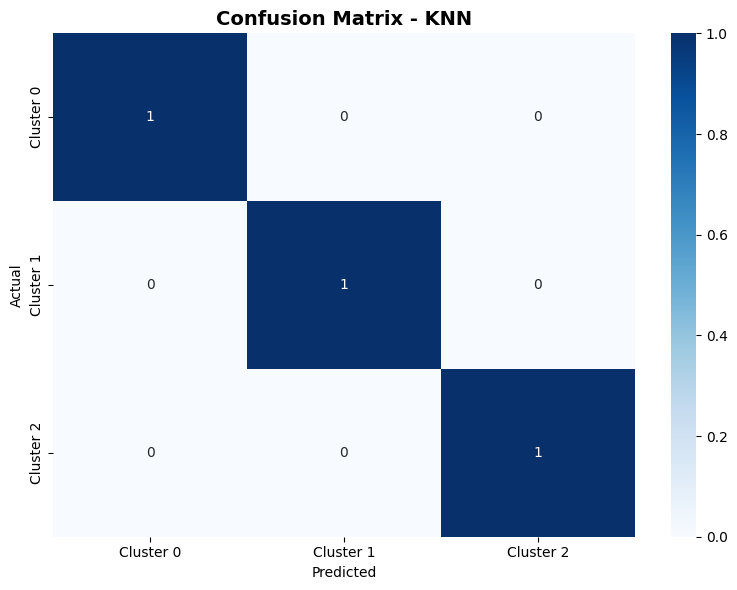

In [12]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title(f'Confusion Matrix - {best_name}', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [13]:
os.makedirs('models', exist_ok=True)

with open('models/sentinel1_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
with open('models/sentinel1_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
df_clean.to_csv('models/sentinel1_data.csv', index=False)

print(f"Saved: models/sentinel1_model.pkl ({best_name}), models/sentinel1_scaler.pkl, models/sentinel1_data.csv")

Saved: models/sentinel1_model.pkl (KNN), models/sentinel1_scaler.pkl, models/sentinel1_data.csv


## Summary

**Objective:** SAR-based glacier surface characterization

**Study Area:** Gangotri Glacier, Uttarakhand Himalayas (30.92°N, 79.08°E)

**Data:**
- Sentinel-1 GRD (2021)
- Period 1: Jan-Feb 2021 (Winter)
- Period 2: Jun-Jul 2021 (Summer)
- DESCENDING orbit, 10m resolution sampling

**Features:**
- VV_2: VV backscatter Period 2
- VV_1: VV backscatter Period 1
- change_VV_VH: Change in VV-VH difference
- Total: 3 features

**Classification:**
- K-Means clustering (3 classes)
- Models: Random Forest, SVM, KNN
- 70/30 train-test split

**Outputs:**
- `models/sentinel1_model.pkl` - Best trained model
- `models/sentinel1_scaler.pkl` - Feature scaler
- `models/sentinel1_data.csv` - Classified data